## Analyzing Used Car Market in Sweden

The project analyzes data scraped from one of Europe's most popular used car listing sites [AutoUncle](https://www.autouncle.se/) and build an ML model that can predict used car prices based on a number of features thereby identifying undervalued or overvalued vehicles in Sweden automobile market.

The data used in the project is collected by webscraping [Autouncle](https://www.autouncle.se/).

### Limitations of the Project

 While the project effectively predicts used car prices and identifies undervalued or overvalued vehicles based on key features like mileage, year, brand, model, transmission, and fuel type, it does not currently account for additional factors that could significantly influence valuation. These factors include the condition of the car (The physical and mechanical state of the car , which is a critical factor for buyers and sellers in assessing value of used cars), prior ownership, engine power, and Geographic pricing trends.  Incorporating these factors in future iterations could enhance the model's accuracy and provide a more comprehensive understanding of the factors driving used car prices.

### Goal

1. Data Acquisition: Collect real-world automobile market data from online sources, leveraging web scraping or available listings, to create a comprehensive dataset of vehicle information.

2. Data Cleaning and Preparation: Process and filter the collected dataset to ensure accuracy and consistency. This includes handling missing values, correcting misaligned data, and standardizing features, making the dataset ready for in-depth analysis and modeling.

3. Machine Learning Model for Price Valuation: Develop a robust machine learning model to estimate automobile prices. The model will use key features such as Mileage, Year, Brand, Model, Transmission, and Fuel Type to predict prices with practical accuracy. The aim is to create a tool that is useful and reliable for price evaluation in real-world scenarios.

4. Market Insights: Analyze the cleaned data and model predictions to uncover meaningful insights about the used car market in Sweden. These insights will support informed decision-making, particularly when purchasing vehicles.

5. Actionable Recommendations: Utilize the model and insights to identify undervalued or overvalued vehicles. This will provide actionable opportunities for both buyers and sellers, helping buyers find good deals and sellers optimize their pricing strategies.

### Workflow

1. Data collection : acquire data by webscraping Europe's largest used car listing site 'autouncle.se'.

2. Data Cleaning : clean, create new features , and transform the scraped dataset in to an analysis ready format.

3. Feature Engineering: Explore additional features, create new features.
    
4. Explore and visualize the data to uncover patterns and anomalies.

5. Data Pre-processing and Build predictive models using machine learning algorithms.

5. Insights and Recommendations

6. Build and deploy a web app on streamlit

## 1. Import Libraries and Load Data

The webscraping part of this project is found in another file.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [13]:
# removes warnings
import warnings
warnings.filterwarnings('ignore')

#suppress scientific notation by setting float_format
pd.options.display.float_format = '{:.2f}'.format

### Load Data

In [14]:
# Load the dataset
def load_data(filepath):
    return pd.read_csv(filepath)

cars_au = load_data('cars_ac.csv')

In [15]:
#cars_au=pd.read_csv('cars_ac.csv')
cars_au.shape

(5525, 8)

In [16]:
cars_au.tail()

,Name,Price,Location,Model_Year,Mileage,Fuel_Type,Gearbox,Gearbox2
5520,VW Golf Variant 1.6 Multifuel Euro 4,33000kr,"nyköping, Södermanland",2009,17871 mil,1.6L Ethanol (E85),Manual,102 HP (75 kW)
5521,VW Golf VII 1.4TSI 140hk GT M&K-Värm Kamera Dr...,95000kr,"Uppsala, Uppsala",1 / 4,Jun 2013,16 387 mil,1.4L Petrol,Manual
5522,"Mercedes EQC400 4MATIC AMG Premium Plus//3,95%...",479000kr,"42536 Hisingskärra, Västra Götaland",2021,3610 mil,Electric,≈ 411 km,Automatic
5523,Nissan Qashqai +2 Qashqai+2 2.0 4x4 CVT 7-Sits...,79900kr,"Rosersberg, Stockholm",Oct 2011,18347 mil,2.0L Petrol,Automatic,142 HP (104 kW)
5524,"Volvo V40 T5 Geartronic Carbon Edition, R Desi...",199990kr,"Kungälv, Västra Götaland",2016,11930 mil,2.0L Petrol,Automatic,245 HP (180 kW)


## 2. Data Cleaning

The dataset is quite messy, and the following steps will be performed systematically to clean and preprocess it:

1.Handle Missing Values:

Identify rows where the Model_Year (in formats like "Year" or "Month Year") is missing.
Remove these rows from the dataset, as the Model_Year is a critical feature.

2.Fix Misaligned Rows:

Address misalignment issues observed in the Model_Year column, where values like '1 / 1', '1 / 2', and '1 / 3' were incorrectly assigned.
Shift such misaligned values to their correct columns.

3.Gearbox Column Issues:

Drop rows where the Gearbox column does not have valid values, i.e., Automatic or Manual.
Remove the Gearbox2 column, as it is redundant and no longer needed.

4.Feature Extraction:

Extract the brand name from the Name column into a new column, Brand.
Extract the model name from the Name column into a new column, Model.

5.Location Cleaning:

Extract only the city name from the Location column into a new column, City.

6.Price Column Cleaning:

Remove the 'kr' suffix from the Price column and convert it to an integer data type.

7.Model_Year Column Cleaning:

Extract only the year value from the Model_Year column, discarding additional information like month names.

8.Combine Brand and Model:

Create a combined column, Brand_Model, to analyze the popularity of specific car models.

9.Mileage Column Cleaning:

Remove rows where the Mileage column contains values like Electric, which are not valid mileage values.
Remove the ' mil' suffix from mileage values and convert the column to an integer data type.

10.Remove Unnecessary Columns:

Drop columns that are irrelevant or redundant after the cleaning process.

11.Data Type Conversion:

Ensure all columns have the appropriate data types (e.g., numeric for mileage, price, and year).

In [17]:
def fix_gear(row):
    if 'km' in str(row['Gearbox']):
        row['Gearbox'] = row['Gearbox2']
        row['Gearbox2'] = None
    return row

# Define a function to fix rows where Model_Year consists of '/'
def fix_row(row):
    if '/' in str(row['Model_Year']):
        row['Model_Year'] = row['Mileage']  # Assign 'Mileage' to 'Model_Year'
        row['Mileage'] = row['Fuel_Type']  # Assign 'Fuel_Type' to 'Mileage'
        row['Fuel_Type'] = row['Gearbox']  # Assign 'Gearbox' to 'Fuel_Type'
        row['Gearbox'] = row['Gearbox2']  # Assign 'Gearbox2' to 'Gearbox'
        row['Gearbox2'] = None  # Clear 'Gearbox2' as it is no longer needed
    return row


def correct_data_types(df):
    df['Price'] = df['Price'].replace('kr', '', regex=True).astype(int)
    df['Mileage'] = df['Mileage'].astype(str).str.replace(r'\D', '', regex=True)
    df['Mileage'] = df['Mileage'].replace('', np.nan).astype(float).astype('Int64')
    df['Year'] = df['Model_Year'].str.extract(r'(\b\d{4}\b)').astype(float)  # Extract year as float
    df = df.dropna(subset=['Year'])  # Drop rows where Year is NaN
    df['Year'] = df['Year'].astype(int)  # Convert remaining years to int
    return df

def clean_data(df):
    df = df.apply(fix_gear, axis=1)
    df = df[df['Gearbox'].isin(['Manual', 'Automatic'])]
    df = df.drop('Gearbox2', axis=1)
    df = df[df['Mileage'] != 'Electric'].reset_index(drop=True)
    df = correct_data_types(df)
    df.rename(columns={'Gearbox': 'Transmission'}, inplace=True)
    df = df.apply(fix_row, axis=1)
    return df

cars_au = clean_data(cars_au)

In [18]:
cars_au.shape

(4036, 8)

## 3. Feature Engineering

- create new column such as Brand, Brand_Model from Name
- categorize Fuel_Type column in to specified six groups
- create a new column called County from the Location column consisting only the county name

The location column has some information that needs to be updated in order to extract a County column.

A function is used to extract the county from the location column.

In [19]:
# Feature Engineering

def feature_engineering(df):
    
    # Extract the brand name from the Name column
    df['Brand'] = df['Name'].str.split(' ').str[0]
    
    # Extract the model name from the Name column
    df['Brand_Model'] = df['Name'].str.split().str[:2].str.join(' ')
    
    # Categorize the Fuel_Type column
    def categorize_fuel_type(fuel_type):
        if 'Electric' in fuel_type and '/' not in fuel_type:
            return 'Electric'
        elif 'Hybrid' in fuel_type or 'Electric/' in fuel_type:
            return 'Hybrid'
        elif 'Petrol' in fuel_type and 'Electric/' not in fuel_type:
            return 'Petrol'
        elif 'Diesel' in fuel_type and 'Electric/' not in fuel_type:
            return 'Diesel'
        elif 'Natural gas' in fuel_type:
            return 'Natural Gas'
        else:
            return 'Ethanol'
    
    # Apply the categorization to the Fuel_Type column
    df['Fuel'] = df['Fuel_Type'].apply(categorize_fuel_type)
    
    # Extract the county from the Location column
    def extract_city(location):
        if 'Delivered to you' in location:
            return None  # Mark rows with 'Delivered to you' for deletion
        elif ',' in location:
            return location.split(',')[1].strip()  # Extract county after comma
        else:
            return location.strip()  # If no comma, return the full location as county
    
    df['County'] = df['Location'].apply(extract_city)
    
    # Drop rows where County is None
    df = df.dropna(subset=['County'])
    
    return df

# Apply feature engineering
cars_au = feature_engineering(cars_au)

In [20]:
cars_au.tail()

,Name,Price,Location,Model_Year,Mileage,Fuel_Type,Transmission,Year,Brand,Brand_Model,Fuel,County
4034,VW Golf 1.6 Multifuel,62000,"kalmar, Kalmar",2009,8845,1.6L Ethanol (E85),Manual,2009,VW,VW Golf,Ethanol,Kalmar
4035,VW Golf Variant 1.6 Multifuel Euro 4,33000,"nyköping, Södermanland",2009,17871,1.6L Ethanol (E85),Manual,2009,VW,VW Golf,Ethanol,Södermanland
4036,"Mercedes EQC400 4MATIC AMG Premium Plus//3,95%...",479000,"42536 Hisingskärra, Västra Götaland",2021,3610,Electric,Automatic,2021,Mercedes,Mercedes EQC400,Electric,Västra Götaland
4037,Nissan Qashqai +2 Qashqai+2 2.0 4x4 CVT 7-Sits...,79900,"Rosersberg, Stockholm",Oct 2011,18347,2.0L Petrol,Automatic,2011,Nissan,Nissan Qashqai,Petrol,Stockholm
4038,"Volvo V40 T5 Geartronic Carbon Edition, R Desi...",199990,"Kungälv, Västra Götaland",2016,11930,2.0L Petrol,Automatic,2016,Volvo,Volvo V40,Petrol,Västra Götaland


In [25]:
cars_au.County.value_counts()

County
Stockholm          1160
Västra Götaland     580
Skåne               541
Dalarna             261
Halland             178
Örebro              160
Södermanland        152
Västmanland         150
Jämtland            132
Kalmar              129
gävle               123
Gotland             123
Uppsala              87
Jönköping            79
Östergötland         49
Kronoberg            25
Blekinge             20
Värmland             17
Västernorrland       12
Gävleborg             8
Västerbotten          8
Norrbotten            6
Name: count, dtype: int64

Retain only the observations in the County column where the count of occurrences is more than 5.

In [22]:
# Remove counties with 1 or 2 observations in the dataset.
county_counts = cars_au['County'].value_counts()
counties_to_keep = county_counts[county_counts > 5].index

# Keep only rows where the County column is in the list of counties to keep
cars_au = cars_au[cars_au['County'].isin(counties_to_keep)]
cars_au.shape

(4000, 12)

In [23]:
cars_au=cars_au.reset_index(drop=True)

In [26]:
cars_au.tail()

,Name,Price,Location,Model_Year,Mileage,Fuel_Type,Transmission,Year,Brand,Brand_Model,Fuel,County
3995,VW Golf 1.6 Multifuel,62000,"kalmar, Kalmar",2009,8845,1.6L Ethanol (E85),Manual,2009,VW,VW Golf,Ethanol,Kalmar
3996,VW Golf Variant 1.6 Multifuel Euro 4,33000,"nyköping, Södermanland",2009,17871,1.6L Ethanol (E85),Manual,2009,VW,VW Golf,Ethanol,Södermanland
3997,"Mercedes EQC400 4MATIC AMG Premium Plus//3,95%...",479000,"42536 Hisingskärra, Västra Götaland",2021,3610,Electric,Automatic,2021,Mercedes,Mercedes EQC400,Electric,Västra Götaland
3998,Nissan Qashqai +2 Qashqai+2 2.0 4x4 CVT 7-Sits...,79900,"Rosersberg, Stockholm",Oct 2011,18347,2.0L Petrol,Automatic,2011,Nissan,Nissan Qashqai,Petrol,Stockholm
3999,"Volvo V40 T5 Geartronic Carbon Edition, R Desi...",199990,"Kungälv, Västra Götaland",2016,11930,2.0L Petrol,Automatic,2016,Volvo,Volvo V40,Petrol,Västra Götaland


## 4.Exploratory Data Analysis (EDA)

##### Brand and Model
Which car brands and models are most available in the used carmarket in Sweden?

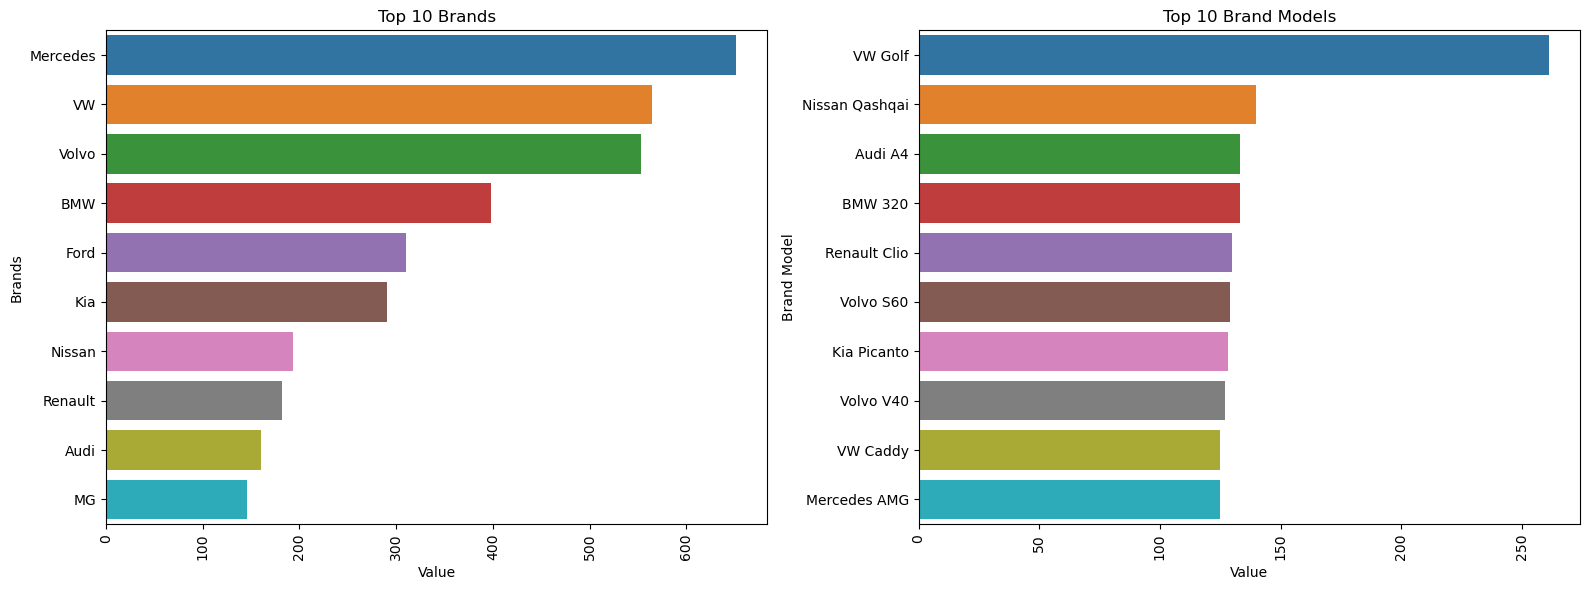

In [27]:

# Data for Brand
var_brand = cars_au['Brand']
var_brand_value_counts = var_brand.value_counts().head(10)

# Data for Brand Model
var_brand_model = cars_au['Brand_Model']
var_brand_model_value_counts = var_brand_model.value_counts().head(10)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for Brand
sns.barplot(ax=axes[0], x=var_brand_value_counts, y=var_brand_value_counts.index)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Brands')
axes[0].set_title('Top 10 Brands')
axes[0].tick_params(axis='x', rotation=90)

# Plot for Brand Model
sns.barplot(ax=axes[1], x=var_brand_model_value_counts, y=var_brand_model_value_counts.index)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Brand Model')
axes[1].set_title('Top 10 Brand Models')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

Volvo has 2 different models in the 10 most popular model category.

##### Distribution of Price of Cars

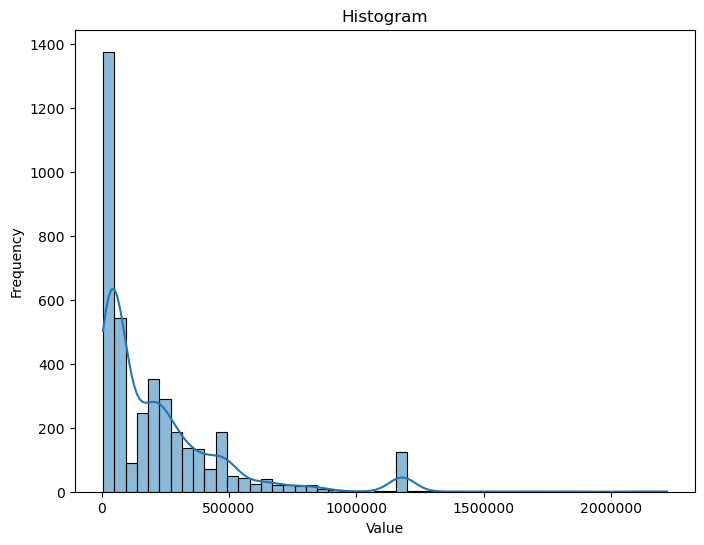

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(cars_au['Price'], bins=50, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.ticklabel_format(style='plain')
plt.show()

##### Relationship between Price, Mileage and Year

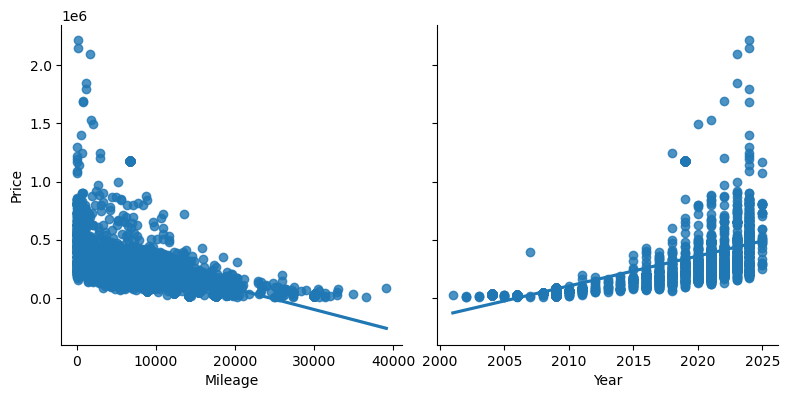

In [29]:
# Create the pairplot
sns.pairplot(cars_au, 
             x_vars=['Mileage', 'Year'],
             y_vars='Price',
             diag_kind='auto',
             kind='reg',
             height=4)

# Show the plot
plt.show()

As the mileage increases, the price of a car decreases. In other words cars with high mileage numbers are sold cheaper on the market.

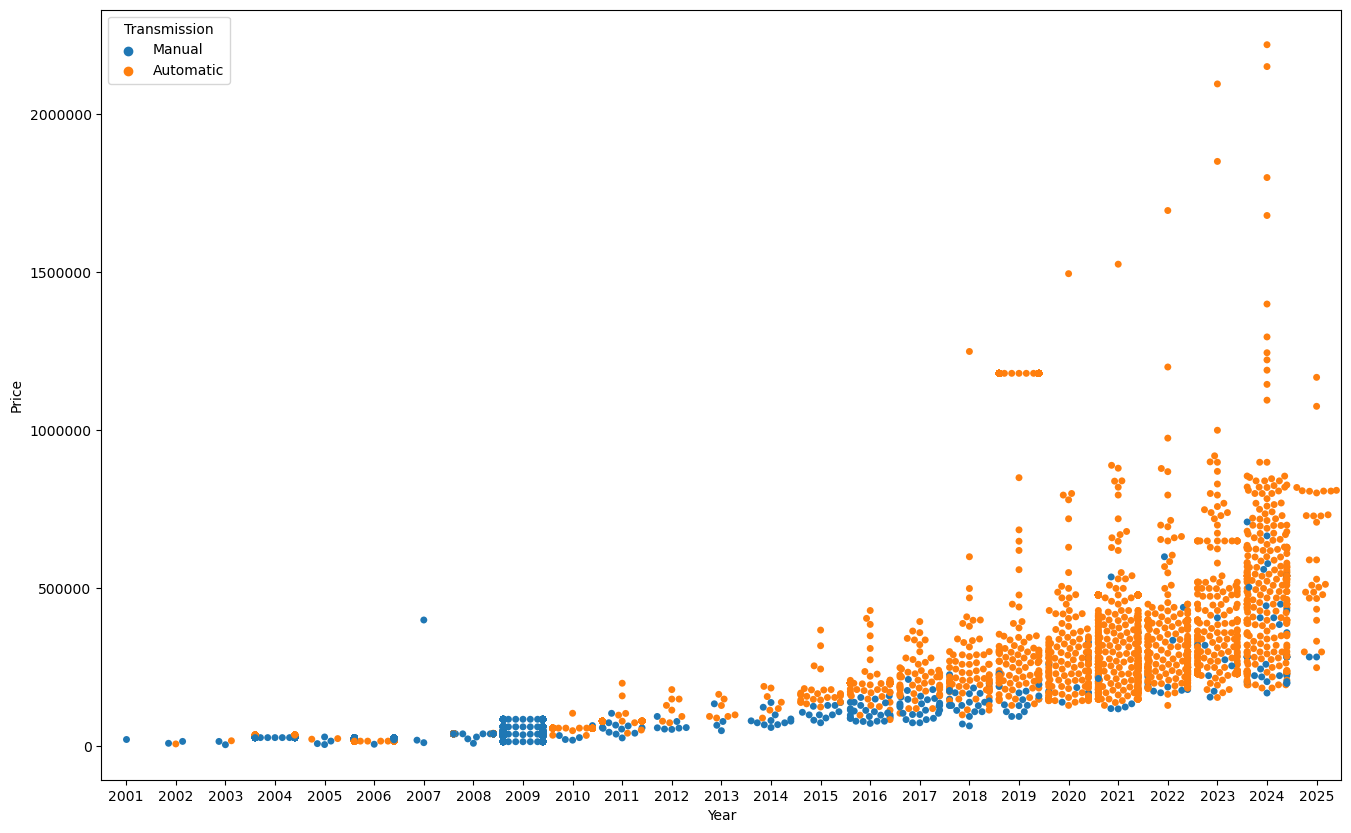

In [19]:
plt.figure(figsize = (16,10))
plt.ticklabel_format(style='plain')
sns.swarmplot(x = 'Year',y = 'Price',data = cars_au,hue='Transmission')
plt.show()

As expected cars with recent make years on average are more expensive on the market. 

There is a noticeable difference in prices between cars with different transmission types within the same year. This is particularly evident in recent years, cars with automatic transmission tend to be priced higher than cars with manual transmission.

The cars with make year in 2007 and 2009 had Manual transmissions.

In [35]:
cars_au[(cars_au['Year']==2009) |(cars_au['Year']==2007)]['Transmission'].value_counts()

Transmission
Manual    738
Name: count, dtype: int64

In [36]:
cars_au.groupby('Fuel')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Fuel,,,,,,,,
Diesel,954.00,124949.58,133055.04,9999.00,39900.00,48900.00,176250.00,879000.00
Electric,690.00,368551.35,187287.69,89800.00,209900.00,349900.00,479000.00,1295000.00
Ethanol,254.00,57059.45,52085.85,33000.00,33000.00,62000.00,62000.00,399900.00
Hybrid,423.00,400587.63,217472.25,129800.00,259900.00,339900.00,459900.00,2149900.00
Natural Gas,124.00,62015.32,40685.33,58000.00,58000.00,58000.00,58000.00,509000.00
Petrol,1555.00,203729.61,333637.58,5500.00,27000.00,79900.00,199990.00,2219000.00


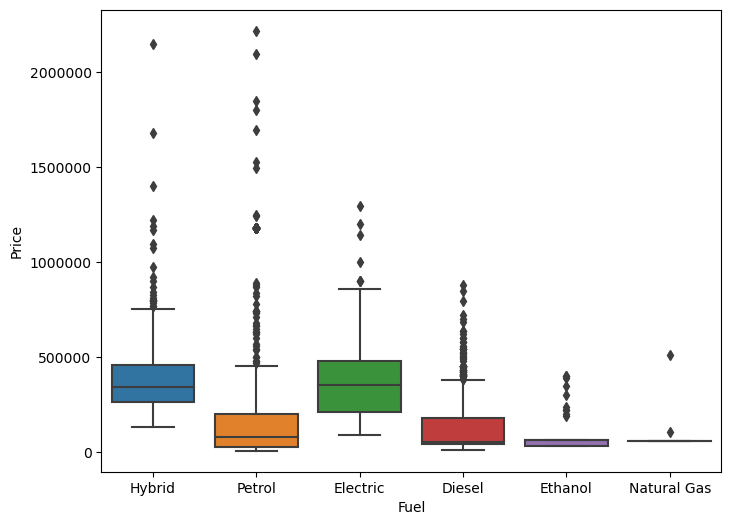

In [37]:
plt.figure(figsize=(8,6))
plt.ticklabel_format(style='plain')
sns.boxplot(x='Fuel',y='Price',data=cars_au)
plt.show()

Cars with diesel and petrol fuel types are relatively cheaper in the used car market than Hybrid and Electric Vehicles.

### Price of Used Cars in Different Counties

Which Counties should Budget-conscious buyers target?

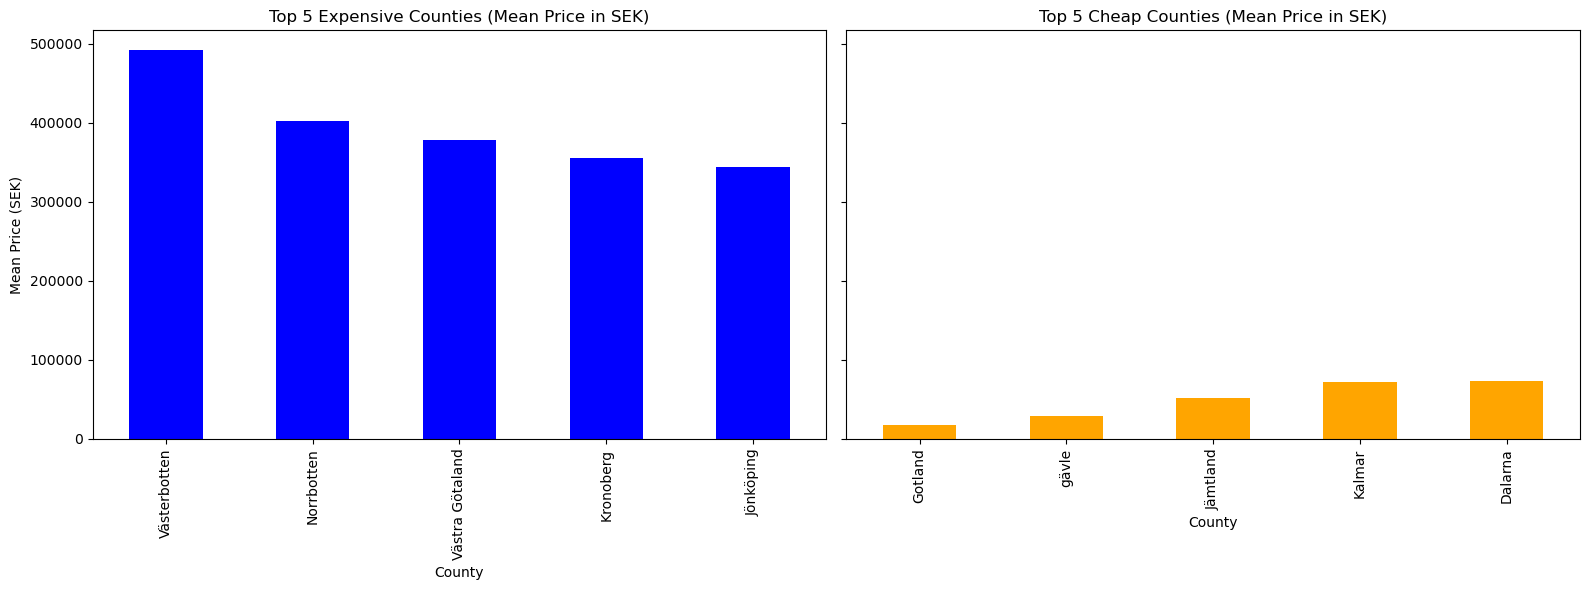

In [51]:
# Calculate the mean prices for expensive and cheap counties
expensive_counties = cars_au.groupby(['County'])['Price'].mean().sort_values(ascending=False).head()
cheap_counties = cars_au.groupby(['County'])['Price'].mean().sort_values().head()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the expensive counties
expensive_counties.plot(
    ax=axes[0],
    kind='bar',
    color='blue',
    title='Top 5 Expensive Counties (Mean Price in SEK)'
)
axes[0].set_ylabel('Mean Price (SEK)')

# Plot the cheap counties
cheap_counties.plot(
    ax=axes[1],
    kind='bar',
    color='orange',
    title='Top 5 Cheap Counties (Mean Price in SEK)'
)

plt.tight_layout()
plt.show()


Check if the price difference among counties is statistically significant

In [39]:
from scipy.stats import f_oneway

# Group the data by County and extract the prices
grouped_data = cars_au.groupby('County')['Price'].apply(list)

# Perform the ANOVA test
anova_result = f_oneway(*grouped_data)
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

F-statistic: 46.144402239569324, p-value: 1.8096785950046664e-170


In [52]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Perform Tukey HSD test
tukey_oneway = pairwise_tukeyhsd(endog=cars_au["Price"], groups=cars_au["County"])

# Convert the summary to a DataFrame
tukey_df = pd.DataFrame(data=tukey_oneway.summary().data[1:], columns=tukey_oneway.summary().data[0])

# Filter the DataFrame to return only rows where reject is True
tukey_filtered = tukey_df[tukey_df['reject'] == True]

# Sort the DataFrame by the absolute value of 'meandiff' in descending order
tukey_sorted = tukey_filtered.reindex(tukey_filtered['meandiff'].abs().sort_values(ascending=False).index)

# Display the top 10 sorted results
tukey_sorted.head(10)


,group1,group2,meandiff,p-adj,lower,upper,reject
53,Gotland,Västerbotten,475157.23,0.00,161519.06,788795.40,True
213,Västerbotten,gävle,-463054.27,0.00,-776692.44,-149416.10,True
104,Jämtland,Västerbotten,440156.82,0.00,127172.29,753141.35,True
133,Kalmar,Västerbotten,420867.64,0.00,107675.21,734060.06,True
34,Dalarna,Västerbotten,418988.60,0.00,110455.54,727521.66,True
211,Västerbotten,Västmanland,-410229.03,0.00,-722138.63,-98319.44,True
214,Västerbotten,Örebro,-405824.31,0.00,-717239.99,-94408.64,True
188,Södermanland,Västerbotten,401390.13,0.00,89584.45,713195.81,True
47,Gotland,Norrbotten,385182.23,0.02,25799.26,744565.19,True
162,Norrbotten,gävle,-373079.27,0.03,-732462.23,-13696.30,True


It is possible to conclude that there is a statistically significant difference in prices among counties. The difference is not due to chance. 
The Tukey pairwise test confirms that it is much expensive to buy used cars in Västerbotten, Norrbotten, and Västra Götland than anywhere else in Sweden. 

It is much cheaper to buy used cars in Gotland, Gävle, Jämtland, Kalmar, and Södermanland than anywhere else in the country, these places also have the lowest GDP-per Capita in Sweden.

Budget-conscious buyers should look closely for cars in these places.


### Price Vs. Brands

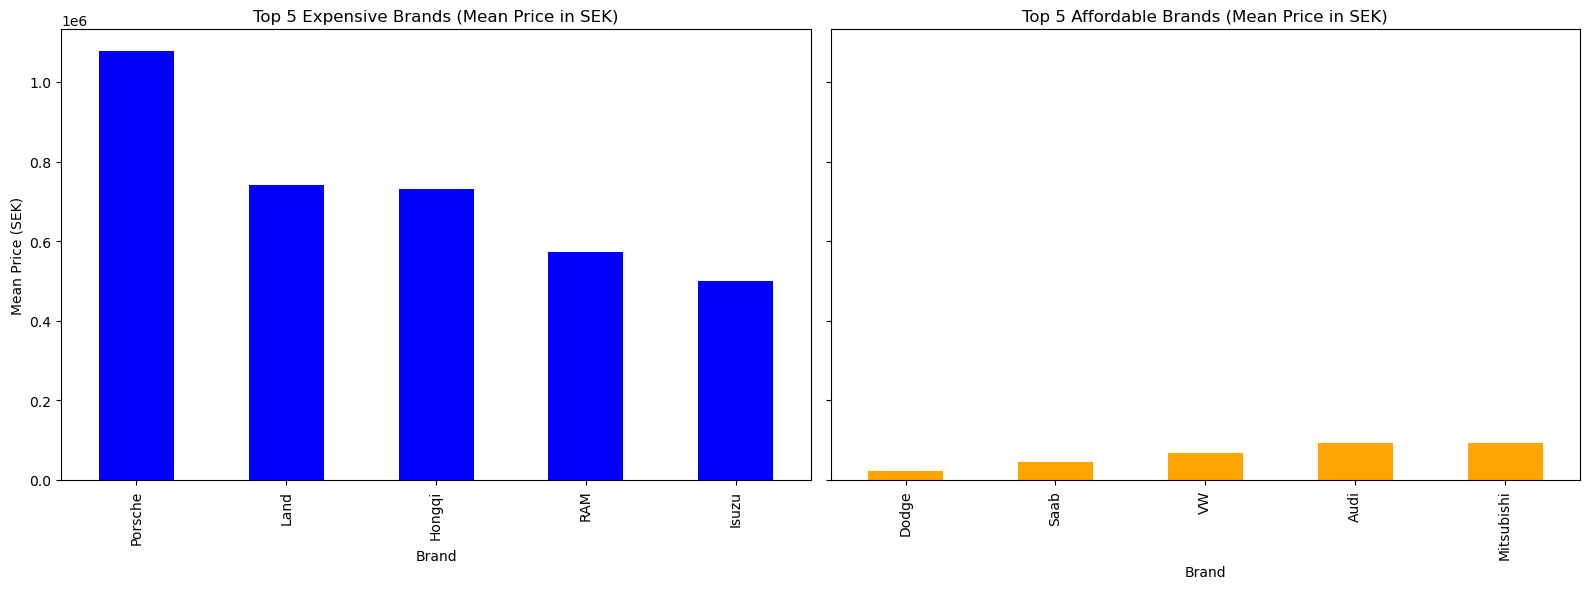

In [53]:
# Calculate the mean prices for expensive and cheap car brands
steep_brand = cars_au.groupby(['Brand'])['Price'].mean().sort_values(ascending=False).head()
affordable_brand = cars_au.groupby(['Brand'])['Price'].mean().sort_values().head()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the expensive brands
steep_brand.plot(
    ax=axes[0],
    kind='bar',
    color='blue',
    title='Top 5 Expensive Brands (Mean Price in SEK)'
)
axes[0].set_ylabel('Mean Price (SEK)')

# Plot the affordable brands
affordable_brand.plot(
    ax=axes[1],
    kind='bar',
    color='orange',
    title='Top 5 Affordable Brands (Mean Price in SEK)'
)

plt.tight_layout()
plt.show()

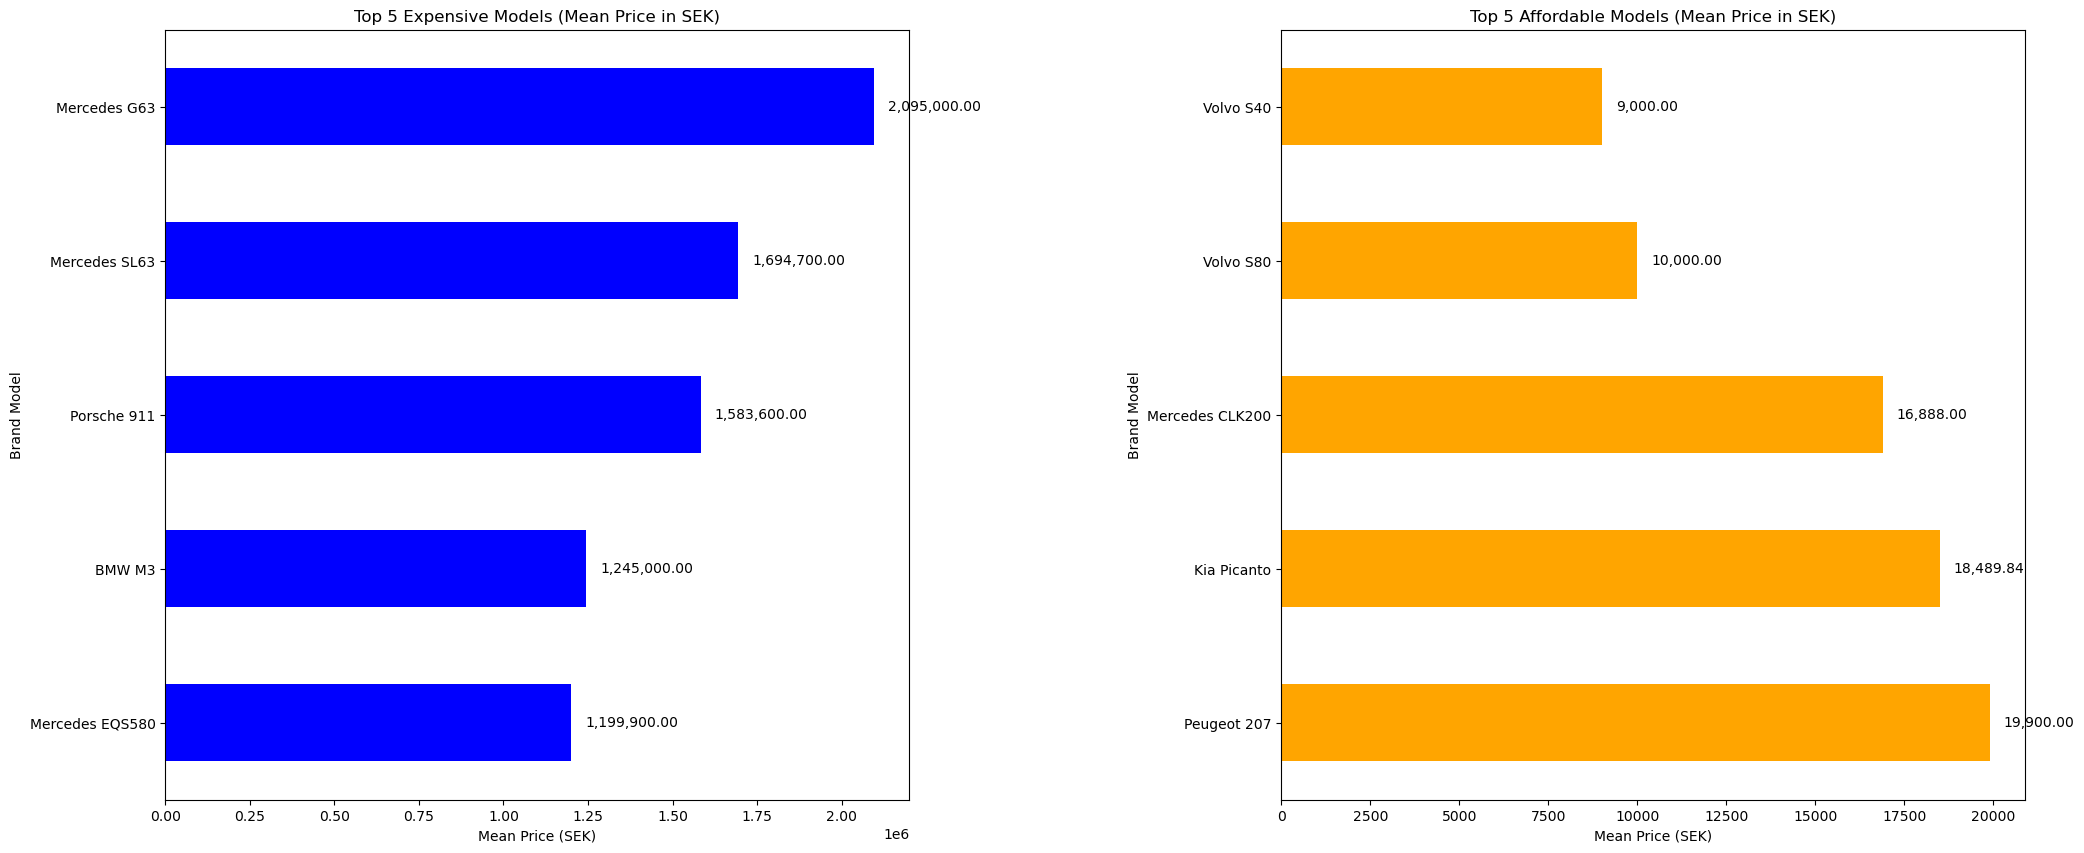

In [68]:

# Group by Brand_Model and calculate the mean prices
steep_model = cars_au.groupby(['Brand_Model'])['Price'].mean().sort_values(ascending=False).head()
affordable_model = cars_au.groupby(['Brand_Model'])['Price'].mean().sort_values().head()

# Create subplots without sharing the y-axis
fig, axes = plt.subplots(
    1, 2,
    figsize=(24, 10),
    gridspec_kw={'wspace': 0.5}  # Add space between the plots
)

# Plot the expensive brands as horizontal bar plot
steep_brand.plot(
    ax=axes[0],
    kind='barh',
    color='blue',
    title='Top 5 Expensive Models (Mean Price in SEK)'
)
axes[0].set_xlabel('Mean Price (SEK)')
axes[0].set_ylabel('Brand Model')  
axes[0].invert_yaxis()  

# Annotate the bars with the mean price values
for i, (index, value) in enumerate(steep_brand.items()):
    axes[0].annotate(f'{value:,.2f}',
                     xy=(value, i),
                     xytext=(10, 0),
                     textcoords='offset points',
                     ha='left',
                     va='center',
                     fontsize=10)

# Plot the affordable brands as horizontal bar plot
affordable_brand.plot(
    ax=axes[1],
    kind='barh',
    color='orange',
    title='Top 5 Affordable Models (Mean Price in SEK)'
)
axes[1].set_xlabel('Mean Price (SEK)')
axes[1].set_ylabel('Brand Model')  
axes[1].invert_yaxis()  

# Annotate the bars with the mean price values
for i, (index, value) in enumerate(affordable_brand.items()):
    axes[1].annotate(f'{value:,.2f}',
                     xy=(value, i),
                     xytext=(10, 0),
                     textcoords='offset points',
                     ha='left',
                     va='center',
                     fontsize=10)

# Adjust layout to add more space between plots
plt.tight_layout()
plt.show()

Volvo S40 and Volvo S80 cars have the lowest average price in the market. Thic could be due to being a popular brand and the availability of spare parts is generally good, leading to competitive pricing. 

Mercedes G63, and Mercedes SL63 have the highest average price in the used car market in Sweden.

In [71]:
cars_au.to_csv('cars_au_to_ml.csv')

## 5. Data Pre-Processing and Modeling

- select important features
- convert categorical columns to numeric.
  
  Most machine learning algorithms require numerical inputs to make predictions. 

  Some of these features have categorical formats and need to be converted in to numeric.
  Brand, Fuel, and Transmission will be converted to numeric format. the technique chosen is One-hot encoding  as the columns are nominal (has no natural order).
- Feature Scaling
  Normalize or standardize numeric features to ensure they are on a comparable scale.
- Train ML models and compare model performances
- Hyperparameter tuning the selected model to achieve better performances using GridSearchCV
- Feature Importance: identify which features are more important

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

# Load the dataset
df = pd.read_csv('cars_au_to_ml.csv')

# Select relevant columns
columns = ['Brand', 'Brand_Model', 'Mileage', 'Fuel', 'Transmission', 'Year', 'County', 'Price']
df = df[columns]

# Check for missing values
print(df.isnull().sum())

# Fill missing values if any
df = df.dropna()

# Separate features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Categorical columns
categorical_cols = ['Brand', 'Brand_Model', 'Fuel', 'Transmission', 'County']

# Numeric columns
numeric_cols = ['Mileage', 'Year']

# Preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)

# Save the scaler
scaler_filename = "scaler.pkl"
joblib.dump(preprocessor, scaler_filename)

Brand           0
Brand_Model     0
Mileage         0
Fuel            0
Transmission    0
Year            0
County          0
Price           0
dtype: int64


['scaler.pkl']

##### Train Test Split

In [77]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=101)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"{name} RMSE: {rmse}.2f")

Linear Regression RMSE: 52557.513375455936.2f
Decision Tree RMSE: 69688.1328827764.2f
Random Forest RMSE: 52174.02062607819.2f
SVR RMSE: 272806.53653011343.2f


##### Hyperparameter Tuning

In [78]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nPerforming Grid Search for Random Forest...")
grid_search = GridSearchCV(RandomForestRegressor(random_state=101), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the optimized Random Forest model
y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nOptimized Random Forest Performance:")
print(f"RMSE = {rmse_best_rf:.2f}, R2 Score = {r2_best_rf:.2f}")


Performing Grid Search for Random Forest...
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Optimized Random Forest Performance:
RMSE = 52068.67, R2 Score = 0.96


### Feature Importance

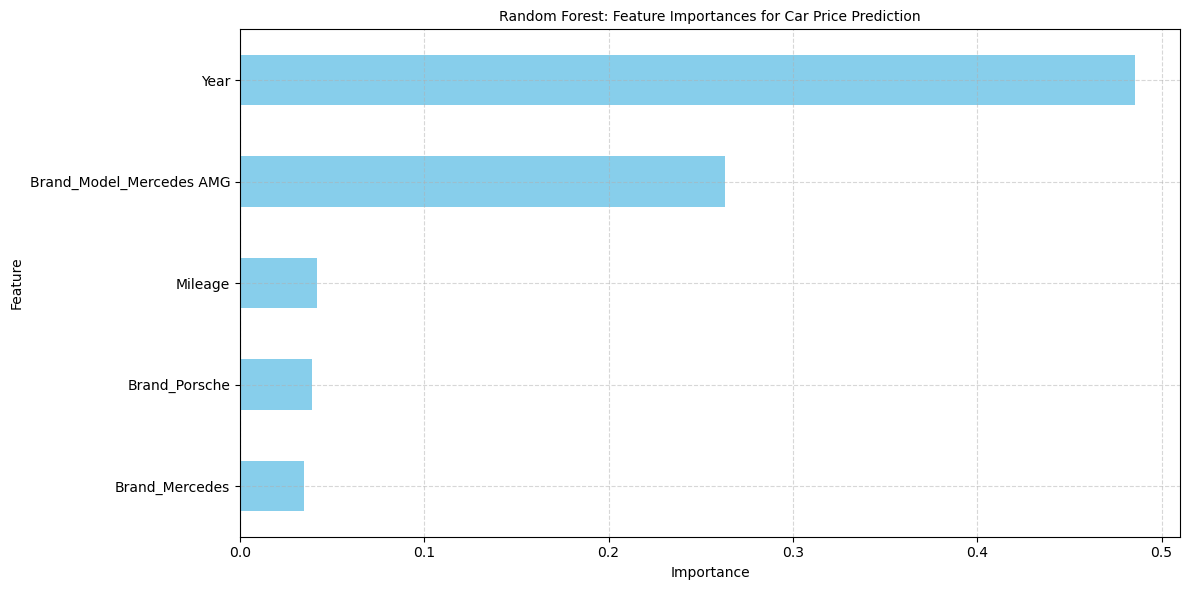

In [79]:
# The ColumnTransformer stores the names in a different structure, so we need to get them
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

# Create a Pandas Series to store feature importances from the model
feature_rank = pd.Series(best_rf.feature_importances_, index=all_features, name='Importance').sort_values(ascending=True, inplace=False)[-5:]

# Plotting a horizontal bar chart to visualize feature importances
ax = feature_rank.plot(kind='barh', figsize=(12, 6), color='skyblue')

# Setting x-axis and y-axis labels, and the title for the plot 
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.title("Random Forest: Feature Importances for Car Price Prediction", fontsize=10)

# Add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The best Random Forest model will be used to identify undervalued cars. 

It is done by comparing predicted prices to actual prices and flagging those with a significant gap. 

In [80]:
#save model
import joblib

joblib.dump(best_rf, 'rf_model.pkl')

['rf_model.pkl']

In [81]:
# Load the saved model
import joblib
loaded_model = joblib.load('rf_model.pkl')

In [82]:
# Predict prices using the test set
predictions=loaded_model.predict(X_test)

##### Set a threshold to identify undervalued cars

In this case, a threshold of 10% was set.

In [90]:
# Calculate the price difference
undervalued_df['Price_Difference'] = undervalued_df['Predictions'] - undervalued_df['Actual']

# Identify undervalued cars with a threshold of 10%
threshold = 0.1
undervalued_mask = undervalued_df['Price_Difference'] > (threshold * undervalued_df['Actual'])

# Filter undervalued cars while preserving original indices
undervalued_df = undervalued_df[undervalued_mask]

# Extract the indices of the filtered undervalued cars (preserving original indices)
filtered_indices = undervalued_df.index

# Extract the original details from df using filtered indices
# Ensure the indices match the original DataFrame structure
original_details = df.loc[filtered_indices, df.columns]

# Combine undervalued DataFrame with original details using original indices
undervalued_with_details = undervalued_df.join(original_details)

# Debugging: Verify the final DataFrame
len(undervalued_with_details)



91

According to the best random forest model, the 91 listed ones above are the most undervalued cars in the dataset,that are priced significantly below their predicted value, signaling potential bargains.

In [92]:
undervalued_with_details.head()

,Actual,Predictions,Price_Difference,Brand,Brand_Model,Mileage,Fuel,Transmission,Year,County,Price
821,369500,450125.00,80625.00,Kia,Kia EV6,7198,Electric,Automatic,2022,Skåne,369500
792,149900,182775.00,32875.00,MG,MG ZS,6163,Electric,Automatic,2020,Halland,149900
589,249900,400664.80,150764.80,MG,MG MG3,49,Hybrid,Automatic,2024,Stockholm,249900
1632,74900,128241.00,53341.00,Fiat,Fiat 500,9425,Petrol,Manual,2017,Skåne,74900
1505,194000,215482.45,21482.45,Audi,Audi A4,9350,Diesel,Automatic,2017,Stockholm,194000


In [93]:
df.iloc[1632]

Brand               Fiat
Brand_Model     Fiat 500
Mileage             9425
Fuel              Petrol
Transmission      Manual
Year                2017
County             Skåne
Price              74900
Name: 1632, dtype: object

Ford have the most number of cars in the undervalued car group.

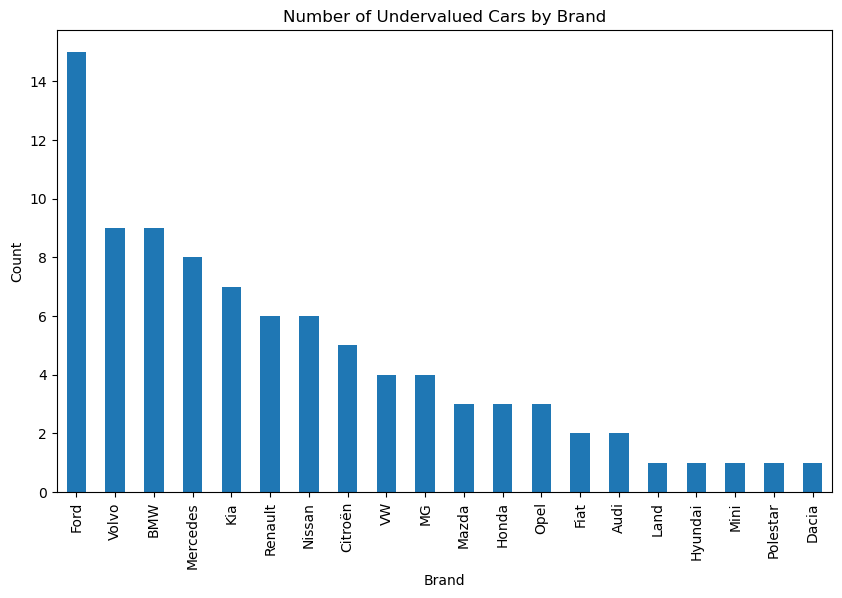

In [89]:
# Plot undervalued cars by brand
undervalued_with_details.groupby('Brand').size().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Number of Undervalued Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

## 6. Insights and Recommendations

The random forest model do not only predict the prices of used cars but also provides actionable insights for identifying potential opportunities in the market for both sellers as well as buyers.

The model identified 91 used cars from the listing that are highly undervalued.


It is much cheaper to buy used cars in Gotland, Gävle, Jämtland, Kalmar, and Södermanland than anywhere else in the country, these places also have the lowest GDP-per Capita in Sweden.

Budget-conscious buyers should look closely for cars in these places.

While the project effectively predicts used car prices and identifies undervalued or overvalued vehicles based on key features like mileage, year, brand, model, transmission, and fuel type, it does not currently account for additional factors that could significantly influence pricing. These factors include:

- Car Condition: The physical and mechanical state of the vehicle, such as wear and tear, accident history, or maintenance records.
- Engine Power: Technical specifications like engine power and performance that often play a crucial role in price valuation.
- Previous Ownership: The number of prior owners, which can impact a car's perceived value and desirability.
- Geographic Pricing Trends: Regional or city-based price differences due to demand, supply, or local market trends.